In [ ]:
import math
from skimage import io, color
from skimage.transform import resize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from skimage.util import img_as_float


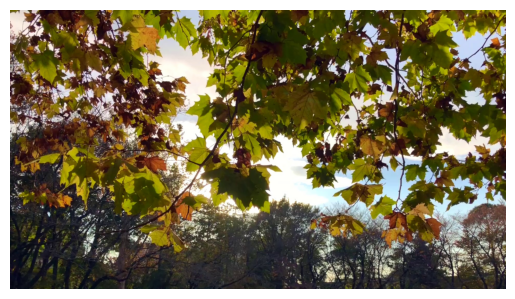

In [2]:
image = cv2.imread('frame_0000.jpg')
inmage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(inmage)
# Display the image using matplotlib
#plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.axis('off')  # Hide axes
plt.show()

In [3]:
# function which returns an object of class SuperPixel
def make_superPixel(h, w,img):
    return SuperPixels(h, w,img[h,w][0],img[h,w][1],img[h,w][2])

In [4]:
def make_superPixel(h, w,img):
    return SuperPixels(h, w,img[h,w][0],img[h,w][1],img[h,w][2])
def initial_cluster_center(S, img, img_h, img_w, clusters):
    num_clusters = (img_h // S) * (img_w // S)
    for _ in range(num_clusters):
        h = np.random.randint(0, img_h-10)
        w = np.random.randint(0, img_w-10)
        clusters.append(make_superPixel(h, w, img))
    return clusters
def calc_gradient(h, w,img,img_w,img_h):
    if w + 1 >= img_w:
        w = img_w - 2
    if h + 1 >= img_h:
        h = img_h - 2
    grad = img[w + 1, h + 1][0] - img[w, h][0] + img[w + 1, h + 1][1] - img[w, h][1] + img[w + 1, h + 1][2] - img[w, h][2]
    return grad
def reassign_cluster_center_acc_to_grad(clusters,img):
    for c in clusters:
        img_h = img.shape[0] 
        img_w = img.shape[1] 
        cluster_gradient = calc_gradient(c.h, c.w,img,img_w,img_h)
        for dh in range(-1, 2):
            for dw in range(-1, 2):
                H = c.h + dh
                W = c.w + dw
                new_gradient = calc_gradient(H,W, img,img_w,img_h)
                if new_gradient < cluster_gradient:
                    c.update(H, W,img[H,W][0], img[H,W][1],img[H,W][2])
                    c_gradient = new_gradient
def assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis, m):
    for c in clusters:
        for h in range(c.h - 2 * S, c.h + 2 * S):
            if h < 0 or h >= img_h: continue
            for w in range(c.w - 2 * S, c.w + 2 * S):
                if w < 0 or w >= img_w: continue
                l, a, b = img[h,w]
                Dc = math.sqrt(math.pow(l - c.l, 2) + math.pow(a - c.a, 2) + math.pow(b - c.b, 2))
                Ds = math.sqrt(math.pow(h - c.h, 2) + math.pow(w - c.w, 2))
                D = math.sqrt(math.pow(Dc / m, 2) + math.pow(Ds /S, 2))
                if D < dis[h,w]:
                    if (h, w) not in tag:
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    else:
                        tag[(h, w)].pixels.remove((h, w))
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    dis[h, w] = D
def avg_color_cluster(img,name,clusters):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        # To change the color of cluster center to Black
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0
    rgb_arr = color.lab2rgb(image)
    rgb_arr = (rgb_arr * 255).astype(np.uint8)
    io.imsave(name, rgb_arr)
    plt.imshow(rgb_arr)
    plt.axis('off')  # Hide axes
    plt.show()

def update_cluster_mean(clusters, img):
    for c in clusters:
        sum_h = sum_w = number = 0
        #print("c.pixels",c.pixels)
        for p in c.pixels:
            sum_h += p[0]
            sum_w += p[1]
            number += 1
            H = sum_h // number
            W = sum_w // number
            c.update(H, W,img[H, W][0], img[H, W][1], img[H, W][2])
    


def slic(labels):
    S, img, img_h, img_w, clusters, tag, dis, k, m = labels
    clusters = initial_cluster_center(S,img,img_h,img_w,clusters)
    reassign_cluster_center_acc_to_grad(clusters,img)
    for i in range(10): # usually the algortihm converges within 10 iterations
        assign_pixels_to_cluster(clusters,S,img,img_h,img_w,tag,dis, m)
        update_cluster_mean(clusters, img)
        if i == 9 : # to print the output after 10 iterations
            name = 'out_m{m}_k{k}.png'.format(loop=i, m=m, k=k)
            avg_color_cluster(img,name, clusters)
    return clusters
# function to convert LAB images back to RGB and save it
def lab2rgb(path, lab_arr):
    rgb_arr = color.lab2rgb(lab_arr)
    rgb_arr = (rgb_arr * 255).astype(np.uint8)
    io.imsave(path, rgb_arr)

# A class to initialize the super pixels, of the form - [h,y,l,a,b].
class SuperPixels(object):

    def __init__(self, h, w, l=0, a=0, b=0):
        self.update(h, w, l, a, b)
        self.pixels = []

    def update(self, h, w, l, a, b):
        self.h = h
        self.w = w
        self.l = l
        self.a = a
        self.b = b

def process_image(image_path, k=100, m=20):
    # read the input RGB image
    rgb = io.imread(image_path, plugin='matplotlib')
    print(rgb.shape)

    # input images are resized to (400 x 400) for processing
    img = resize(rgb, (400, 400), anti_aliasing=True)
    print(img.shape)

    # convert RGB to LAB
    img = color.rgb2lab(img)

    img_h = img.shape[0]  # Image Height
    img_w = img.shape[1]  # Image Width

    N = img_h * img_w  # Total number of pixels in the image
    S = int(math.sqrt(N / k))  # average size of each superpixel

    clusters = []
    tag = {}
    # initialize the distance between pixels and cluster center as infinity
    dis = np.full((img_h, img_w), np.inf)

    return (S, img, img_h, img_w, clusters, tag, dis, k, m)


/tmp/ipykernel_875274/188694272.py:114: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  rgb = io.imread(image_path, plugin='matplotlib')


(1080, 1920, 3)
(400, 400, 3)


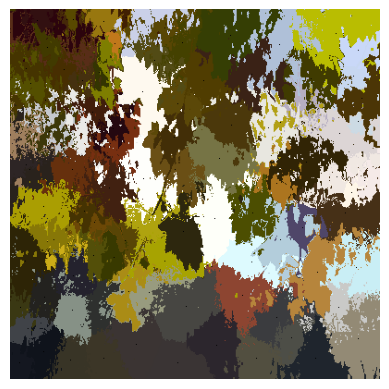

In [5]:
labelsdef = process_image("frame_0000.jpg")
cluster = slic(labelsdef)

/tmp/ipykernel_875274/188694272.py:114: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  rgb = io.imread(image_path, plugin='matplotlib')


(1080, 1920, 3)
(400, 400, 3)


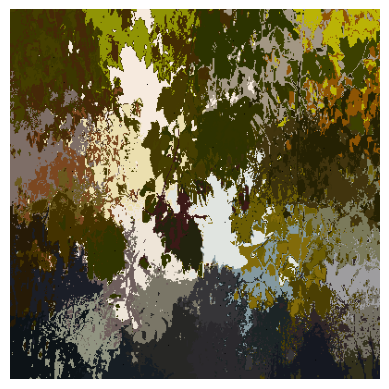

In [6]:

# Example usage
labels5010 = process_image("frame_0000.jpg", k=50, m=10)
cluster = slic(labels5010)

/tmp/ipykernel_875274/188694272.py:114: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  rgb = io.imread(image_path, plugin='matplotlib')


(1080, 1920, 3)
(400, 400, 3)


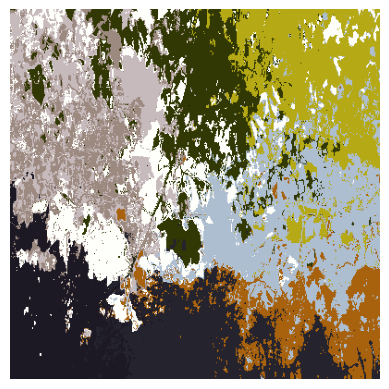

In [7]:

# Example usage
labels51015 = process_image("frame_0000.jpg", k=10, m=15)
cluster = slic(labels51015)

/tmp/ipykernel_875274/188694272.py:114: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  rgb = io.imread(image_path, plugin='matplotlib')


(1080, 1920, 3)
(400, 400, 3)


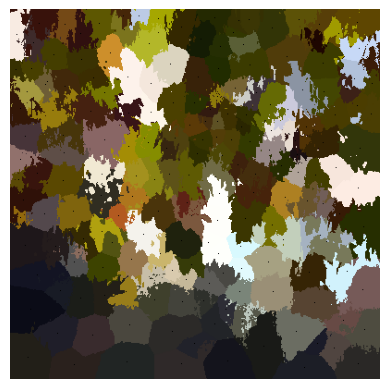

In [8]:

# Example usage
labelswut = process_image("frame_0000.jpg", k=200, m=50)
cluster = slic(labelswut)

In [38]:
# superpixels
for c in cluster:
    print("H {} : W {}, l {}, a {}, b {}".format(c.h,c.w,c.l,c.a,c.b))

# Segmenting the Video

In [19]:
def segment_video(video_path, output_folder, k=100, m=20):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    frame_count = 0
    clusters = []
    tag = {}
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Resize the frame
        img = resize(frame_rgb, (400, 400), anti_aliasing=True)
        
        # Convert RGB to LAB
        img = color.rgb2lab(img)
        
        img_h = img.shape[0]  # Image Height
        img_w = img.shape[1]  # Image Width
        
        N = img_h * img_w  # Total number of pixels in the image
        S = int(math.sqrt(N / k))  # Average size of each superpixel
        
        # Initialize the distance between pixels and cluster center as infinity
        dis = np.full((img_h, img_w), np.inf)
        
        # Process the frame
        if frame_count == 0:
            clusters = initial_cluster_center(S, img, img_h, img_w, clusters)
            reassign_cluster_center_acc_to_grad(clusters, img)
            for i in range(10):  # Usually the algorithm converges within 10 iterations
                assign_pixels_to_cluster(clusters, S, img, img_h, img_w, tag, dis, m)
                update_cluster_mean(clusters, img)
                if i == 9:  # Save the output after 10 iterations
                    path = os.path.join(output_folder, f'out_frame_{frame_count}.png')
                    avg_color_cluster(img, path, clusters)
        else:
            for i in range(4):  # Usually the algorithm converges within 4 iterations
                assign_pixels_to_cluster(clusters, S, img, img_h, img_w, tag, dis, m)
                update_cluster_mean(clusters, img)
                if i == 3:  # Save the output after 4 iterations
                    path = os.path.join(output_folder, f'out_frame_{frame_count}.png')
                    avg_color_cluster(img, path, clusters)
        
        frame_count += 1
    
    # Release everything if job is finished
    cap.release()
    cv2.destroyAllWindows()

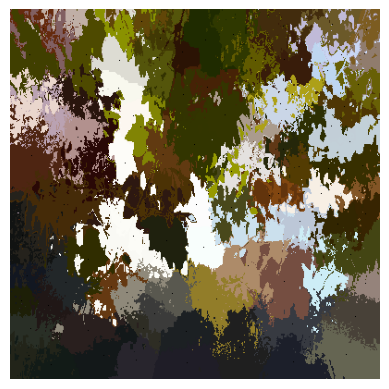

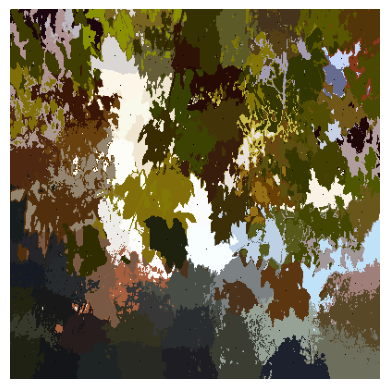

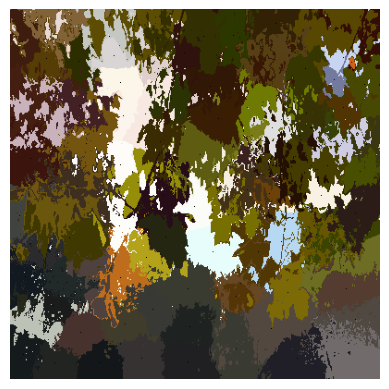

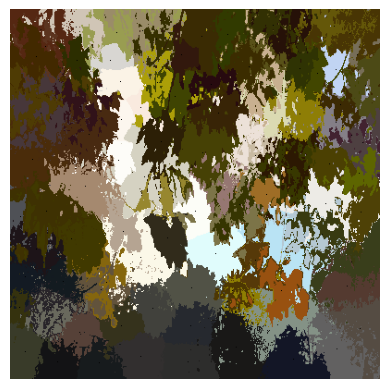

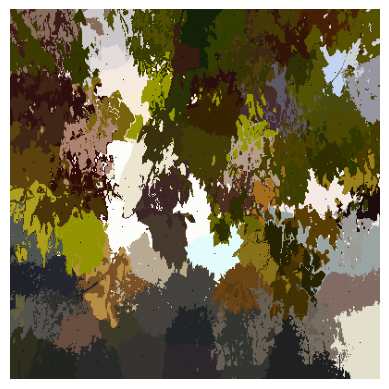

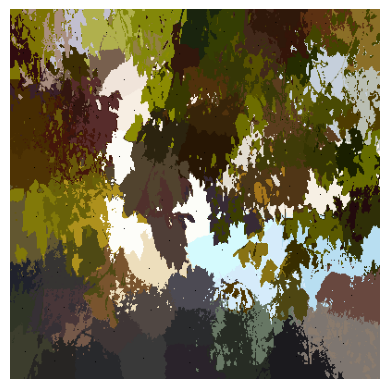

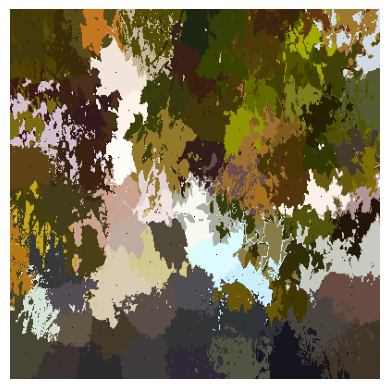

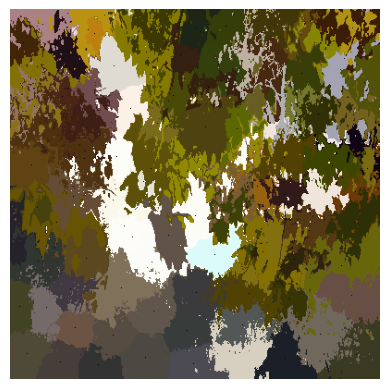

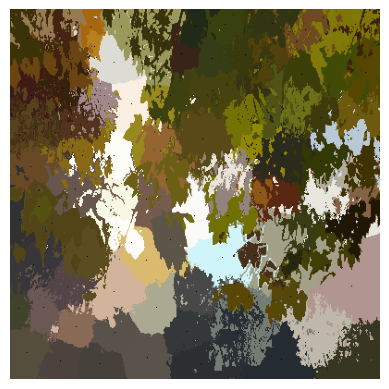

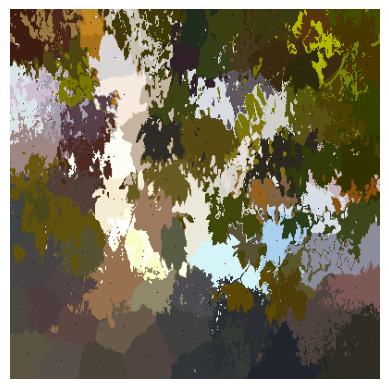

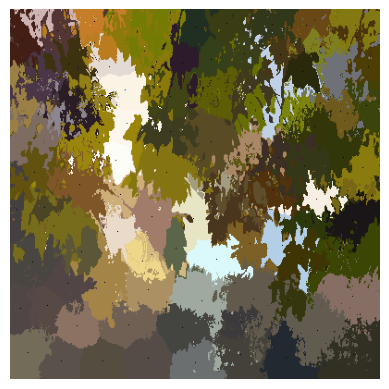

In [20]:
segment_video('SMAI_A1/input.mp4', 'output_frames', k=100, m=20)

# Video Segmantation but like this time it is more optimised 

In [29]:
def process_image(img, k=100, m=20):
    img_h = img.shape[0]  # Image Height
    img_w = img.shape[1]  # Image Width
    N = img_h * img_w  # Total number of pixels in the image
    S = int(math.sqrt(N / k))  # Average size of each superpixel
    clusters = []
    tag = {}
    dis = np.full((img_h, img_w), np.inf)
    return (S, img, img_h, img_w, clusters, tag, dis, k, m)

def process_video(video_path, output_dir, k=100, m=20, max_iters=10):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()
    if not ret:
        print("Error: Could not read video.")
        return
    
    prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2RGB)
    prev_frame_lab = color.rgb2lab(resize(prev_frame, (400, 400), anti_aliasing=True))
    prev_labels = process_image(prev_frame_lab, k, m)
    prev_clusters = slic(prev_labels)
    
    frame_idx = 0
    while ret:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_lab = color.rgb2lab(resize(frame, (400, 400), anti_aliasing=True))
        
        # Use previous frame’s clusters as initialization
        labels = process_image(frame_lab, k, m)
        clusters = slic(labels)  # Reduce iterations
        
        output_path = os.path.join(output_dir, f"frame_{frame_idx:04d}.png")
        avg_color_cluster(frame_lab, output_path, clusters)
        
        prev_clusters = clusters
        frame_idx += 1
    
    cap.release()
    print("Processing complete. Output saved to:", output_dir)


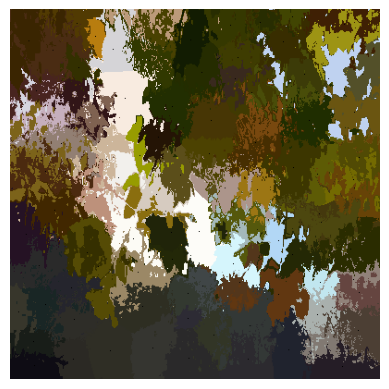

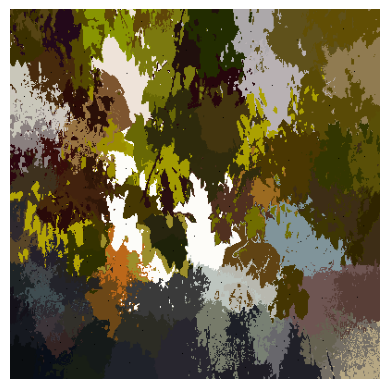

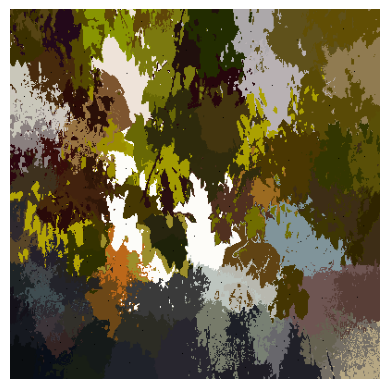

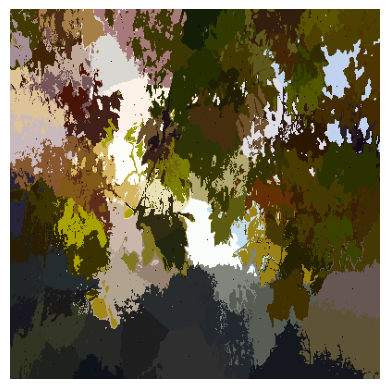

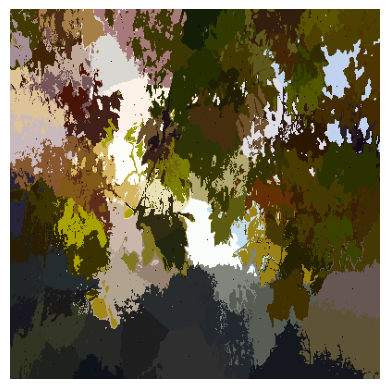

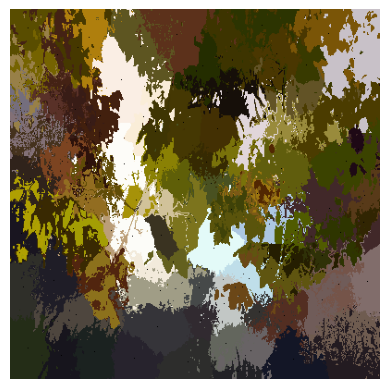

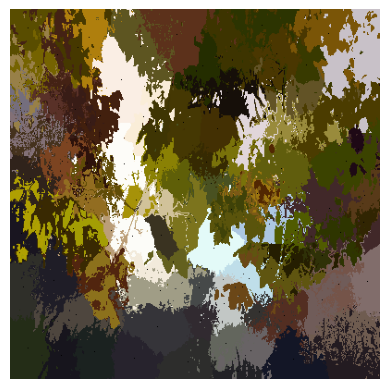

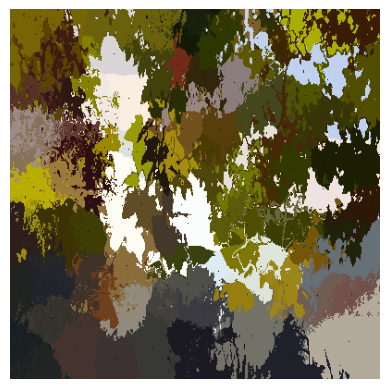

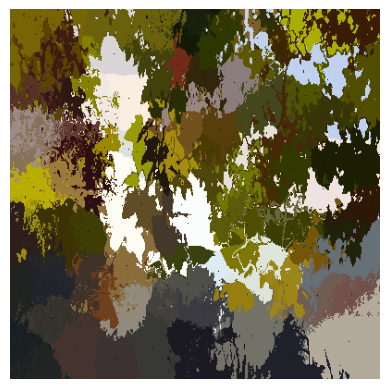

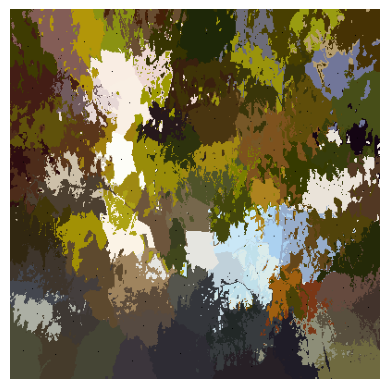

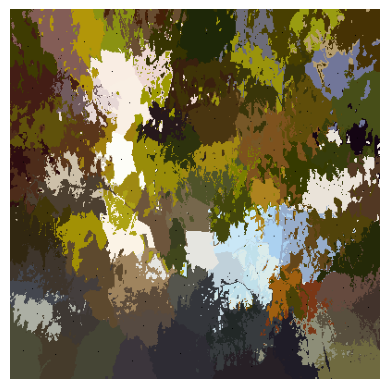

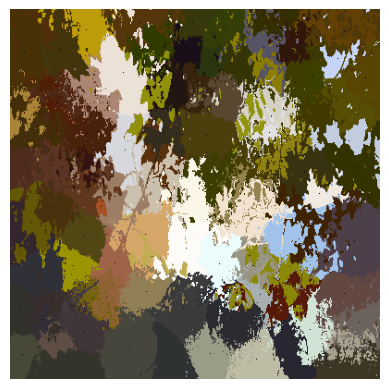

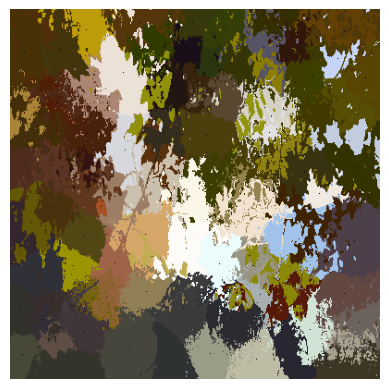

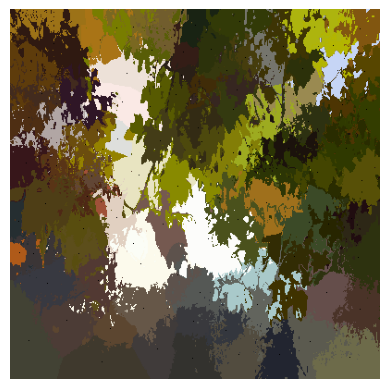

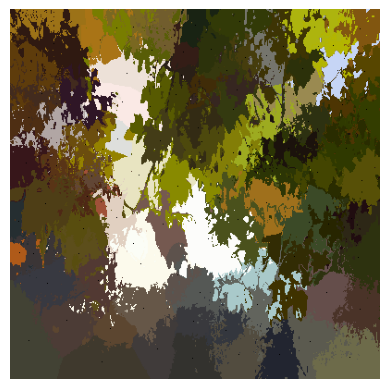

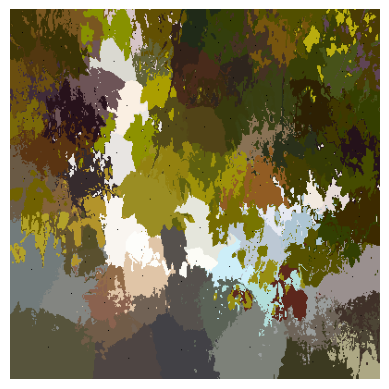

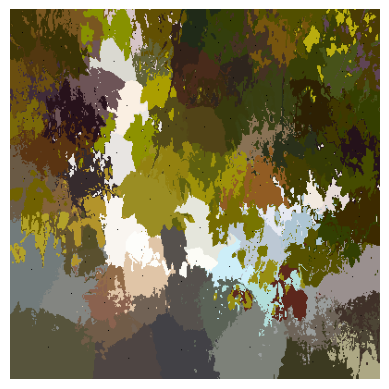

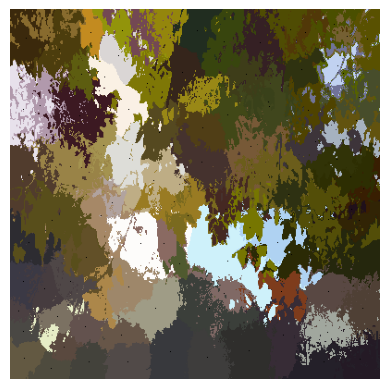

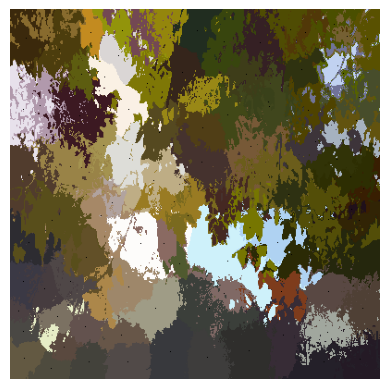

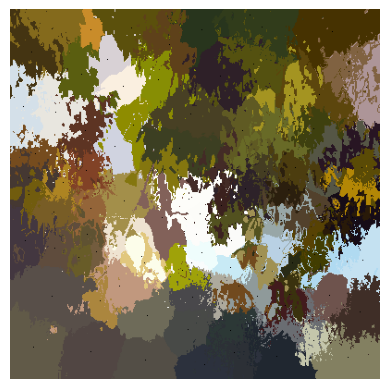

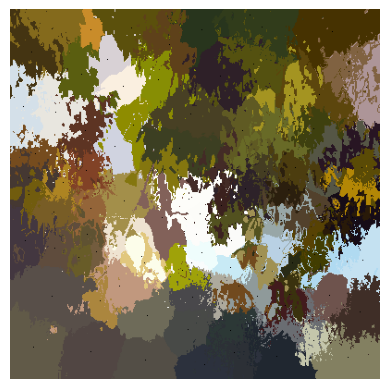

Processing complete. Output saved to: output_frames2


In [30]:
process_video('SMAI_A1/input.mp4', 'output_frames2', k=100, m=20)